# The HFM library - A fast marching solver with adaptive stencils

## Part : Applications
## Chapter : Radar detection models

Solving eikonal equations allows to compute paths minimizing a variety of energies. 
A use case of interest is to minimize the probability of detection by a surveillance device, along a trajectory. For instance an airplane or a drone may attempt to avoid detection by a radar, and this type of model and assumption may in principle be incorporated in the radar design and configuration.

In this notebook, I present some toy models for the probability of detection, as well as the mathematical frameworks and algorithmic tools that can be used to express them and extract the corresponding optimal paths.

**Probability of detection.**

The probability of non-detection of a vehicle moving along a trajectory $\gamma:[0,T] \to R^2$ is modeled as 
$$
    P(\gamma) = \exp\Big[- \int_0^T C^0_{\xi(t)}(\gamma(t), \gamma'(t)) \ \mathrm{d}t\Big]
$$
where $c_\xi(x,v)$ is the instantaneous probability of detection of a vehicle located at position $x$, with velocity $v$, and with detection devices configured by some parameters $\xi$.

The radar design problem can therefore be formulated as the following two player game:
$$
    \max_{\xi \in \Xi} \min_{\gamma \in \Gamma} \int_0^T C^0_{\xi(t)}(\gamma(t), \gamma'(t)) \ \mathrm{d}t,
$$
where $\Gamma$ is the set of all admissible trajectories, and $\Xi$ is the set of all feasible radar configuration parameters.

**Time dependence.**

If the detection device parameters change over time, that is if $\xi = \xi(t)$ varies as time $t$ changes, then a time-dependent PDE is required to compute the optimal path and cost. This approach is discussed in the notebooks devoted to boat routing, with a [quadratic](../../Notebooks_NonDiv/BoatRouting_Time.ipynb) or a [generic](../../Notebooks_NonDiv/BoatRoutingGeneric_Time.ipynb) cost function. 

In this notebook we limit our attention to a static configuration $\xi = \xi_0$ of the detection devices. We also assume that the time at which the target is reached is not constrained, in other words that the trajectories $\gamma \in \Gamma$ can be freely reparametrized, say by unit euclidean length. 

The adressed problem can therefore be reformulated as 
$$
    \max_{\xi \in \Xi} \min_{\gamma \in \Gamma} \int_0^L C_\xi(\gamma(l), \gamma'(l)) \ \mathrm{d}l,
$$
where we denoted by $C$ the cost function corresponding to a trajectory that is travelled at optimal velocity, obtained as 
$$
    C(x,v) := \min_{\lambda > 0} \frac{C^0(x,\lambda v)}{\lambda}.
$$

**Admissible trajectories.**

Airborne vehicles have maneouverability constraints, and in particular they cannnot rotate in place, or make excessively sharp turns, or oscillate at high frequency between different heading directions. 

In order to account for this property, we may restrict the set of admissible trajectories $\Gamma$ to include only those whose curvature (inverse radius of curvature) is below a given threshold. 

Alternatively we may require the vehicle to slow down when doing tight turns. Note that this breaks the reparametrization invariance assumed in the previous paragraph. 

In both cases these constraints are numerically implemented by penalizing the *curvature* of the incident path, introducing the modified trajectory cost:
$$
    \int_0^L C_\xi(\gamma(l), \gamma'(l)) \ E(|\gamma''(l)|) \ \mathrm{d}l,
$$
where $E$ embeds the desired curvature bound or penalization. The following expressions are used
$$
    E(\kappa) = 1+(\xi \kappa)^2,
    \quad \text{ or } \quad
    E(\kappa) = \begin{cases}
        1 \text{ if } \xi \kappa \leq 1\\
        \infty \text{ otherwise}.
    \end{cases}
$$
where $\xi$ is an inverse radius of curvature. These two penalizations are known as the Dubins and the Euler-Mumford elastica model.

**Detection models.**

One of the objectives of this notebook is to illustrate the variety of the detection models.

As a function of the detector-target distance:
* *Blind distances.* Depending on the *pulse repetition inverval*, a radar may not be able to detect objects at multiples of a given distance.
* *Obstruction by obstacles.*

As a function of the detector-target relative orientation:
* *Blind radial speeds.* Depending on the *pulse frequency*, a radar may not be able to detect objects whose radial speed is the multiple of a given value. If the target is moving at a fixed velocity, then this translates into blind relative angles for the detector.
* *Radar equivalent area.* The amount of radar reflected by an object strongly depends on its features and on their relative orientation w.r.t the radar.

Realistic radar models feature all of the above complexities simultaneously, as well as numerous other, and various constraints - e.g. a lower bound on the product of the pulse frequency and the pulse repetition interval.


**Optimization.**

The problem of interest is defined as a two-level optimization, over $\gamma$ and $\xi$ successively.

* *Minimum over $\gamma \in \Gamma$.* We extract, up to discretization errors, the globally optimal trajectory among all admissible $\gamma \in \Gamma$, and the corresponding minimal cost. For that purpose, the problem is reformulated in the form of a generalized Eikonal partial differential equation, which is discretized and solved numerically.

* *Maximum over $\xi \in \Xi$.* The optimization over $\xi \in \Xi$ is usually non-convex and non-differentiable. The HFM library is able to compute the gradient of the objective w.r.t $\xi$, which can be used within a generic optimization routine such as gradient ascent or BFGS.

**References.**

The numerical experiments presented in this notebook are inspired by the following publication. 
* Dreo, J., Desquilbet, F., Barbaresco, F., & Mirebeau, J.-M. (2019). Netted multi-function radars positioning and modes selection by non-holonomic fast marching computation of highest threatening trajectories. Presented at the International RADAR’19 conference.



## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Curvature','FMM'))

In [466]:
from agd import Eikonal
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd.Interpolation import map_coordinates
norm = ad.Optimization.norm
#from agd.Plotting import savefig, SetTitle3D; #savefig.dirName = 'Figures/Curvature/'

In [3]:
import numpy as np; xp=np
from matplotlib import pyplot as plt

In [442]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,Metrics
    Eikonal,ad,Metrics = rreload([Eikonal,ad,Metrics],rootdir='../..')

## 1. Position dependent detection

In this section, we focus on variations of the detection probability depending solely on the position of the target.


### 1.1 Setting

We fix a domain, and a coordinate grid.

In [146]:
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[-2.5,0],
})

hfmIn.SetRect([[-3,3],[-2,2]],dimx=300)
hfmIn.SetUniformTips((4,3))

X = hfmIn.Grid()
dx = hfmIn['gridScale']

In [94]:
radars_pos = np.array([[-1,-1.5],[1,1],[2,-0.5]]).T # Multiple radars
radar_pos  = np.array([0,0]) # Centered single radar

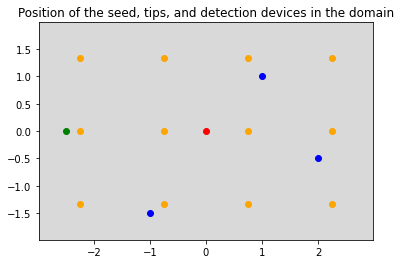

In [99]:
plt.title("Position of the seed, tips, and detection devices in the domain")
plt.contourf(*X,0*X[0],cmap='Greys') # Get correct limits
plt.scatter(*hfmIn['seed'],color='green')
plt.scatter(*hfmIn['tips'].T,color='orange')
plt.scatter(*radars_pos,color='blue') 
plt.scatter(*radar_pos,color='red'); 

### 1.2 Blind distances

In the blind distances model, detection probability decays with the radar-target distance, but also strongly oscillates.

In [45]:
def OscillatingDecay(r):
    return (1.5 - np.cos(3*np.pi*r)) / (1+r**2)

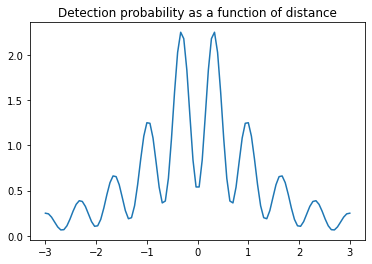

In [46]:
plt.title("Detection probability as a function of distance")
r = np.linspace(-3,3,100)
plt.plot(r, blind_r(r));

In [72]:
def BlindDistanceProba(target,detector):
    """
    Detection probability for a target located at x, 
    from a detector located at p.
    """
    target,detector = fd.common_field((target,detector),depths=(1,1))
    r = norm(target-detector,axis=0)
    return OscillatingDecay(r)

In [112]:
detection_cost = BlindDistanceProba(X,radar_pos)
fuel_cost = 0.5
hfmIn['cost'] = detection_cost + fuel_cost

In [113]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.016256 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


The optimal trajectories doge the radars through the blind corridors. 
Note that a constant cost, referred as "fuel cost", was added to eliminate excessively long trajectories.

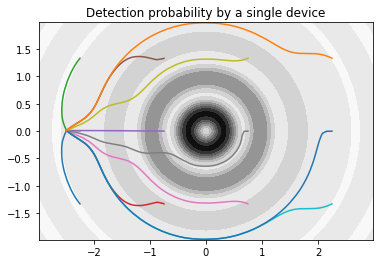

In [114]:
plt.title("Detection probability by a single device")
plt.contourf(*X,hfmIn['cost'],cmap="Greys")
for geo in hfmOut['geodesics']: plt.plot(*geo)

In [116]:
np.repeat(X,5,axis=1).shape

(2, 1500, 200)

In the case of several detection devices, we add the corresponding probability fields, regarding them as independent.

In [117]:
detection_cost = sum(BlindDistanceProba(X,pos) for pos in radars_pos.T)
fuel_cost = 0.5
hfmIn['cost'] = detection_cost + fuel_cost

In [118]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.014745 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


Again, the optimal trajectories go through 'blind corridors', and avoid the hot spots where the detection probability reaches a local maximum.

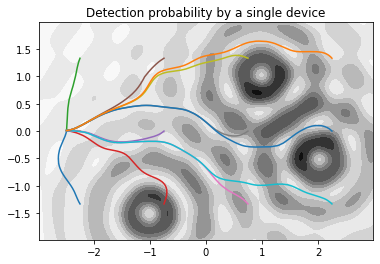

In [119]:
plt.title("Optimal trajectories")
plt.contourf(*X,hfmIn['cost'],cmap="Greys")
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 1.3 Obstacles

A radar cannot usually see behind obstacles, or inside deep valleys.
In this section, we check for such obstructions and take them into account in the detection probability map.

We assume that the detection device is placed at height $h_D$, and the target flies at height $h_T$, above the ground whose $z$-map is given. Then we simply check that the detector-target straight line does not intersect the ground.


<!---
PDE approach seems to fail.
Matrix is large, non-symmetric, ...
--->

<!---
def max_along(u,value,direction,dx):
    """
    Null residue of this PDE operator characterizes,
    the maximum of value along direction.
    """
    sign = np.sign(direction)
    z = np.zeros_like(sign[0])
    offsets = np.array([[sign[0],z],[z,sign[1]]]).astype(int)
    du = fd.DiffUpwind(u,offsets,dx)
    
    coef = np.abs(direction)
    deriv = (coef*du).sum(axis=0)
    return np.minimum(u-value,-deriv)
--->

In [336]:
def Occlusion(xD,x,z, hD=0.2,hT=0.1,nS=50):
    """
    Returns the maximum height difference between 
    the straight detector-target line, and the 
    obstacles as described in the height map.
    """
    zD = hD+np.squeeze(map_coordinates(z,np.expand_dims(xD,axis=-1),grid=x),axis=-1)
    zT = hT+z
    xD = fd.as_field(xD,z.shape)
    zDiff = np.zeros_like(z)
    for s in np.linspace(0,1,nS):
        zLine = (1-s)*zD+s*zT
        x0 = (1-s)*xD+s*x
        z0 = map_coordinates(z,x0,grid=x)
        zDiff = np.maximum(zDiff,z0-zLine)
    return zDiff

For simplicity, we generate a synthetic height map.

In [334]:
def bump(x,x0,σ,e=2): 
    x,x0 = fd.common_field((x,x0),depths=(1,1))
    r = norm(x-x0,axis=0)/σ
    return np.exp(-r**e)

#zmap = bump(X,[-2,2],2) + bump(X,[1.5,-1],1) + bump(X,[-2,-0.5],1) \
#- 0.5*(bump(X,[2,1],1) + bump(X,[1,1],1) + bump(X,[0,0.5],1) )

flat_peak = [-1.5,0]
pointy_peak = [1.5,0.5]
zmap = 2*bump(X,flat_peak,1) + 3*bump(X,pointy_peak,1,e=1)

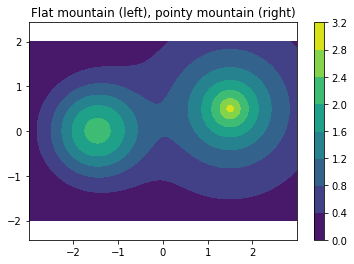

In [335]:
plt.title("Flat mountain (left), pointy mountain (right)")
plt.contourf(*X,zmap)
plt.colorbar(); plt.axis('equal');

In [369]:
positions = ([-0.5,-1],flat_peak,pointy_peak)
occlusions = [Occlusion(pos,X,zmap) for pos in positions]
distances = [norm(X-fd.as_field(pos,hfmIn.shape),axis=0) for pos in positions]

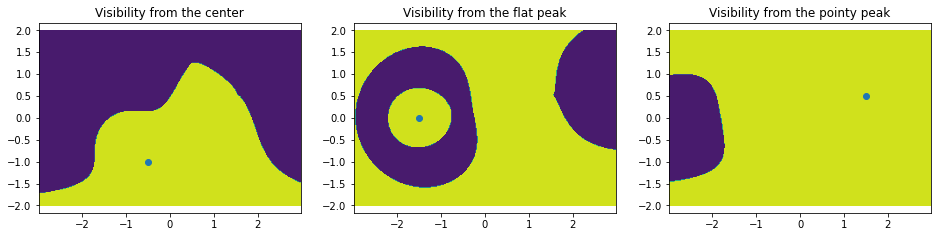

In [370]:
plt.figure(figsize=(16,3.5))

for i,(pos,place,occl) in enumerate(zip(
    positions,("center","flat peak","pointy peak"),occlusions)):
    plt.subplot(1,3,1+i)
    plt.title(f"Visibility from the {place}")
    plt.contourf(*X,occl<=0)
    plt.scatter(*pos)
    plt.axis('equal')

In [371]:
hfmIn['cost'] = 0.5+sum((occl==0) / (1+dist**2) for occl,dist in zip(occlusions,distances))

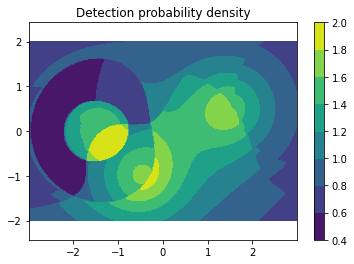

In [378]:
plt.title('Detection probability density')
plt.contourf(*X,hfmIn['cost'])
plt.colorbar(); plt.axis('equal');

In [373]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.01497 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


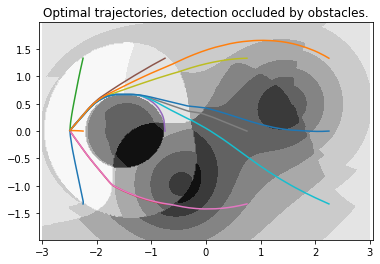

In [392]:
plt.title("Optimal trajectories, detection occluded by obstacles.")
plt.contourf(*X,hfmIn['cost'],cmap="Greys")
plt.axis('equal')
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 1.4 Curvature penalization and anisotropy

In this section, we considered detection probabilities depending only on the plane position. As a result, the standard isotropic fast marching method is able to compute the corresponding optimal trajectories. Anisotropic models needed in the next section when as the detection probability depends on the target orientation, in addition to its direction.

However, one may still want to use an anisotropic model in this section, in order to account for the vehicle manoeuverability constraints, and to impose an initial and a final orientation.



In [389]:
curvIn = Eikonal.dictIn({
    'model':'Dubins2',
    'xi':0.8, # Min radius of curvature
    'cost':hfmIn['cost'],
    'seed':(*hfmIn['seed'],2*np.pi/3),
    'tips':[(*tip,np.pi/4) for tip in hfmIn['tips']],
})
curvIn.SetRect([[-3,3],[-2,2]],dimx=300)
curvIn.nTheta = 96 # Discretization of [0,2*pi] 

In [390]:
curvOut = curvIn.Run()

Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 15.2241 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985


The lower bound on the curvature radius, and the fixed starting and ending orientations, yield trajectories substantially distinct from the non-curvature penalized ones.

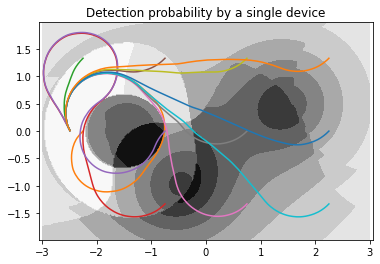

In [391]:
plt.title("Optimal Dubins trajectories, detection occluded by obstacles.")
plt.contourf(*X,curvIn['cost'],cmap="Greys")
plt.axis('equal')
for geo in curvOut['geodesics']: plt.plot(*geo[:2])

## 2. Orientation dependent cost

In this section, we consider orientation dependent detection probabilities. By construction, the isotropic fast marching method is therefore excluded.

### 2.1 Radar cross section

The *radar cross-section* (RCS) is a measure of how detectable an object is by radar, see [wikipedia](https://en.wikipedia.org/wiki/Radar_cross-section). The radar cross section depends on many factors, such as the object material and the radar wavelength. Another factor of interest is the relative orientation of the radar and object. Computing the radar cross section is a numerical challenge in itself.

Fix the positions of the radar and object, and denote by $\theta$ the heading direction of the later. The RCS is often a complicated, and oscillating function of $\theta$. However, simpler behavior also makes sense: for instance, furtive planes are often designed to be especially hard to detect from the front, so as to approach their objective undetected, at the expense of the sides and possibly the back. 

We illustrate such a model here, using the asymmetric quadratic metrics class, of the form
$$
    F_x(v) := \sqrt{ <v,M(x) v> + <w(x),v>_+^2},
$$
where $M$ is a field of positive definite matrices, and $w$ is a vector field.

We use an ad-hoc function to produce a metric with the desired shape.

In [506]:
radar_direction = [1.,0.5]
radar_front_detection = 0.5
radar_back_detection = 1
radar_side_detection = 2
metric = Metrics.AsymQuad.needle(radar_direction,radar_front_detection,radar_side_detection,radar_back_detection)

In [507]:
u,v = radar_direction/norm(radar_direction)
assert np.allclose([metric.norm([u,v]),metric.norm([-u,-v]),metric.norm([v,-u]),metric.norm([-v,u])],
                   [radar_front_detection,radar_back_detection,radar_side_detection,radar_side_detection])

Alternatively the metric may be specified directly in terms of its quadratic and linear parts.

In [508]:
metric.m, metric.w

(array([[ 1.  , -1.5 ],
        [-1.5 ,  3.25]]),
 array([-0.77459667, -0.38729833]))

The achievable distance for a unit probability of detection is longest when one is heading toward the radar. A crucial point is that the level lines of this distance are convex (this holds by construction of asymmetric quadratic norms). 
The case of a non-convex profile is discussed in the next section.

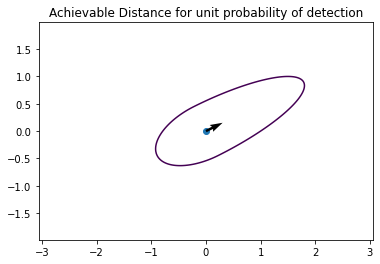

In [512]:
plt.title("Achievable Distance for unit probability of detection")
plt.axis('equal')
plt.scatter(0,0) # Initial position
plt.quiver(0,0,*radar_direction) # Arrow points towards radar
plt.contour(*X,metric.norm(X),levels=[1]);

The detection probability density is the inverse of the above distance, and is thus anisotropic - depending on the direction of travel. It is closely related to the radar cross section.

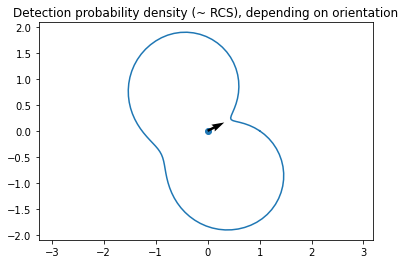

In [522]:
plt.title("Detection probability density (~ RCS), depending on orientation")
θ = np.linspace(0,2*np.pi,100)
u = np.array([np.cos(θ),np.sin(θ)])
plt.plot(*(u * metric.norm(u)))
plt.scatter(0,0) # Center point
plt.quiver(0,0,*radar_direction) # Arrow points towards radar
plt.axis('equal');

We build the RCS related metric as a product of two factors : 
* An anisotropic part, depending on the relative orientation of the detector and target
* An isotropic part, decaying as one moves away from the radar.

In [632]:
def RCSMetric(radar_pos,X,*args,**kwargs):
    X,radar_pos = fd.common_field((X,radar_pos),depths=(1,1))
    u = radar_pos - X # Radar direction, for anisotropic part
    r = norm(u,axis=0) # Radar distance, for the isotropic part
    return Metrics.AsymQuad.needle(u,*args,**kwargs).with_cost(0.5+1/(1+r**2))

In [633]:
hfmIn['model'] = 'AsymmetricQuadratic2'
hfmIn.pop('cost',None);
hfmIn['verbosity']=0

In [636]:
detections = (0.5,2,1) # forward, side, reverse
radar_pos = [0,1.]
hfmIn['metric'] = RCSMetric(radar_pos,X,*detections)

In [ ]:
hfmOut = hfmIn.Run()

The optimal trajectories move preferentially towards and away from the radar, avoiding showing the side of the vehicle.
Amusingly, many trajectories go through the radar position, and in this way completely avoid showing their side. This could be avoided by further increasing the detection probability very close to the radar.

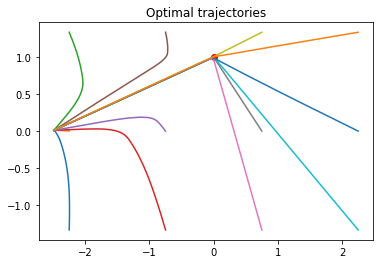

In [639]:
plt.title("Optimal trajectories")
plt.scatter(*radar_pos,color='red')
for geo in hfmOut['geodesics']: plt.plot(*geo)

In the case of several detection devices, we can sum the components of the corresponding asymmetric quadratic metrics. This yields an underestimate of the sum of the corresponding detection probabilities (whose algebraic structure is not suitable for the HFM algorithm).

In [651]:
metrics = [RCSMetric(pos,X,*detections) for pos in radars_pos.T]
hfmIn['metric'] = Metrics.AsymQuad(sum(metric.m for metric in metrics), sum(metric.w for metric in metrics))
hfmIn.SetUniformTips((8,6))

In [652]:
hfmOut = hfmIn.Run()

Again, several trajectories go through the radar positions, whereas others stay away from them.

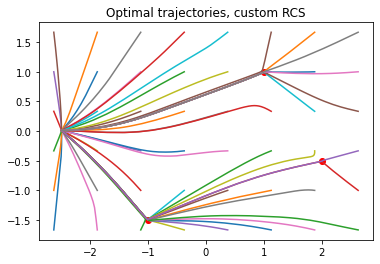

In [654]:
plt.title("Optimal trajectories, custom RCS")
plt.scatter(*radars_pos,color='red')
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 2.2 Blind radar velocities